# CA3 Experiment

In [36]:
# import dependencies
from BSE import market_session
from BSE_utils import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Example experiment from BSE workshop

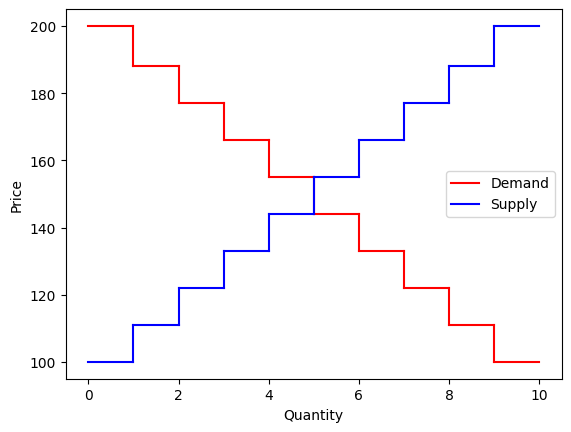

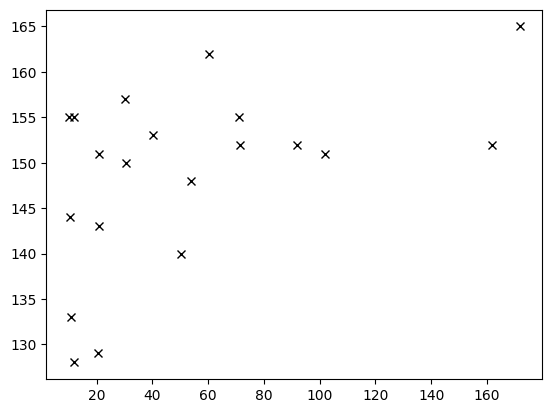

In [33]:
# example experiment from BSE workshop

# First, configure the trader specifications
sellers_spec = [('ZIP', 10)]
buyers_spec = [('ZIP', 10)]
traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

# Next, confiure the supply and demand (and plot it)
sup_range = (100, 200)
dem_range = (100, 200)

stepmode = 'fixed'

plot_sup_dem(10, [sup_range], 10, [dem_range], stepmode)

# Next, configure order schedules

start_time = 0
end_time = 3*60
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': stepmode}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': stepmode}]

order_interval = 10
order_sched = {
    'sup': supply_schedule,
    'dem': demand_schedule,
    'interval': order_interval,
    'timemode': 'periodic'
}

trial_id = 'output/test_1'
tdump = open(trial_id + '_avg_balance.csv','w')
dump_all = True
verbose = False

# Now, run the market session
market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

# Finally, plot the trades that executed during the market session
plot_trades(trial_id)

## Methodology

### Hypothesis

All traders are just as profitable as each other.

### Experiment setup

Start the experiment conditions simple (static market) to gain an understanding of how the whole process will run end-to-end. The experiment will run for 10 minutes with 10 ZIP buyers and sellers and a fixed supply and demand range of (100, 200) for both. The stepmode will be jittered to introduce some randomness and the traders will receive their orders every 10s periodically with some random noise.

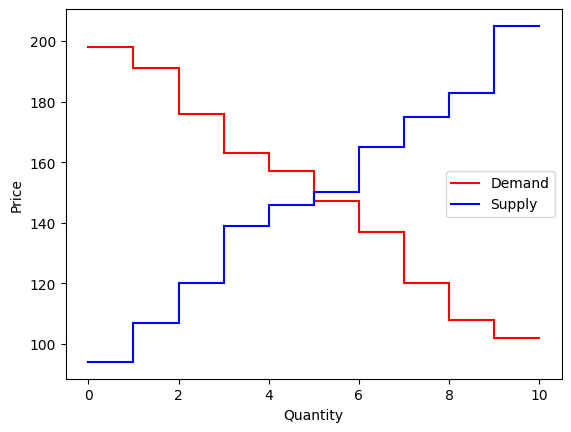

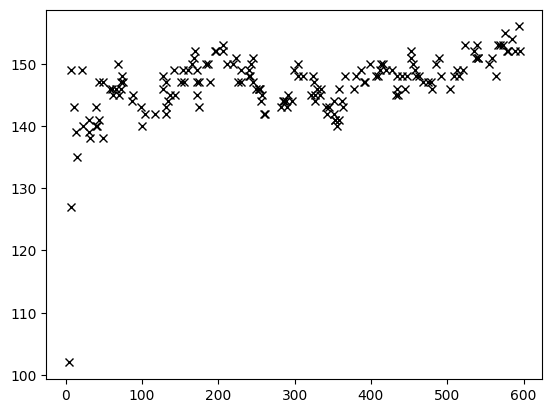

In [125]:
# configure the trader specifications
sellers_spec = [('ZIP', 10)]
buyers_spec = [('ZIP', 10)]
traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

# confiure the supply and demand (and plot it)
sup_range = (100, 200)
dem_range = (100, 200)

stepmode = 'jittered'

plot_sup_dem(10, [sup_range], 10, [dem_range], stepmode)

# configure order schedules
start_time = 0
end_time = 10*60
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': stepmode}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': stepmode}]

order_interval = 10
timemode = 'drip-jitter'
order_sched = {
    'sup': supply_schedule,
    'dem': demand_schedule,
    'interval': order_interval,
    'timemode': timemode
}

trial_id = 'output/trial_1'
tdump = open(trial_id + '_avg_balance.csv','w')
dump_all = True
verbose = False

# run market session
market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

# plot the trades that executed during the market session
plot_trades(trial_id)

Now completing the same experiment but for n trials. The total and average profits are stored in a df. The config from the previous experiment will be reused for simplicity.

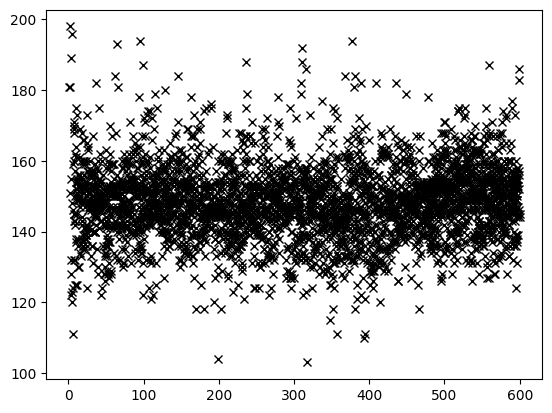

In [146]:
# number of simulations
num_trials = 10

# traders
traders = ['ZIP', 'ZIC', 'GVWY', 'SHVR', 'SNPR']

def run_n_trials(num_trials, start_time, end_time, traders_spec, order_sched, tdump):
    # declare output lists
    x = np.empty(0)
    y = np.empty(0)

    # create profits df
    col_names = [trader + suffix for trader in traders for suffix in ['_tot', '_avg']]
    profits_df = pd.DataFrame(columns=col_names)

    for i in range(num_trials):
        # generate trial id
        trial_idn = trial_id + "." + str(i)

        # open dump file
        tdump = open(trial_idn + '_avg_balance.csv','w')

        # run simulation
        market_session(trial_idn, start_time, end_time, traders_spec, order_sched, tdump, False, False)
        
        # close dump file
        tdump.close()

        # store trades from trial
        with open(trial_idn + '_tape.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)
        
        # store total and avg profits for each trader in df
        with open(trial_idn + '_avg_balance.csv', newline='') as profitsfile:
            reader = csv.reader(profitsfile)

            for j, row in enumerate(reader):
                # append row of zeroes to df
                profits_df.loc[len(profits_df)] = 0

                for k, item in enumerate(row[4:], start=1): # iterate from traders onward
                    if not k % 4: # average profit
                        col_name = row[k].replace(" ", "") + '_avg'
                        profits_df.loc[profits_df.index[i], col_name] = float(item)

                    elif not k % 2: # total profit
                        col_name = row[k + 2].replace(" ", "") + '_tot'
                        profits_df.loc[profits_df.index[i], col_name] = float(item)

    # plot trades
    plt.plot(x, y, 'x', color='black')

    return profits_df

profits_df = run_n_trials(num_trials, start_time, end_time, traders_spec, order_sched, tdump)

Running this experiment for n trials generates a lot of csv files. To retreive the profits from each file the column to the right of the trader name contains the total profits from each trial.

In [147]:
profits_df['SNPR_tot'].any()

True

In [148]:
profits_df

,ZIP_tot,ZIP_avg,ZIC_tot,ZIC_avg,GVWY_tot,GVWY_avg,SHVR_tot,SHVR_avg,SNPR_tot,SNPR_avg
0,4745,790.833333,2251,375.166667,1054,175.666667,1895,315.833333,2072,345.333333
1,925,154.166667,1845,307.500000,4896,816.000000,8274,1379.000000,689,114.833333
2,3294,549.000000,1561,260.166667,5320,886.666667,4456,742.666667,961,160.166667
3,6984,1164.000000,1836,306.000000,4873,812.166667,142,23.666667,1099,183.166667
4,2602,433.666667,2820,470.000000,6697,1116.166667,4823,803.833333,468,78.000000
5,4818,803.000000,2807,467.833333,3409,568.166667,3195,532.500000,1259,209.833333
6,3993,665.500000,4539,756.500000,3651,608.500000,6321,1053.500000,540,90.000000
7,4831,805.166667,1225,204.166667,6623,1103.833333,2689,448.166667,696,116.000000
8,3969,661.500000,229,38.166667,4806,801.000000,5812,968.666667,1224,204.000000
9,4271,711.833333,2334,389.000000,4862,810.333333,3896,649.333333,1007,167.833333


In [149]:
profits_df['ZIP_avg'].mean()

673.8666667

Let's run this with all of the available traders now

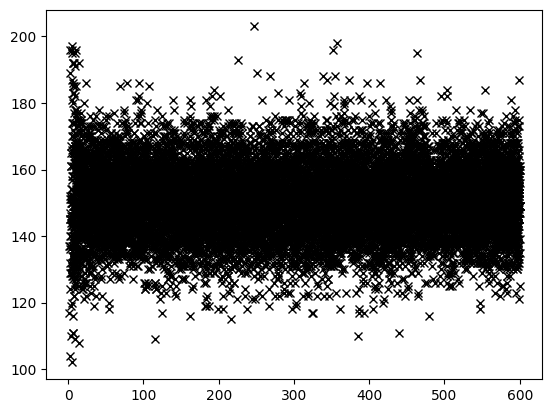

In [161]:
num_trials = 50

# configure the trader specifications
sellers_spec = [('ZIP', 3), ('ZIC', 3), ('GVWY', 3), ('SHVR', 3), ('SNPR', 3)]
buyers_spec = sellers_spec
traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

# confiure the supply and demand (and plot it)
sup_range = (100, 200)
dem_range = (100, 200)

stepmode = 'jittered'

# configure order schedules
start_time = 0
end_time = 10*60
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': stepmode}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': stepmode}]

order_interval = 10
timemode = 'drip-jitter'
order_sched = {
    'sup': supply_schedule,
    'dem': demand_schedule,
    'interval': order_interval,
    'timemode': timemode
}

trial_id = 'output/trial_2'
tdump = open(trial_id + '_avg_balance.csv','w')

profits_df = run_n_trials(num_trials, start_time, end_time, traders_spec, order_sched, tdump)

In [162]:
profits_df

,ZIP_tot,ZIP_avg,ZIC_tot,ZIC_avg,GVWY_tot,GVWY_avg,SHVR_tot,SHVR_avg,SNPR_tot,SNPR_avg
0,4619,769.833333,972,162.000000,8050,1341.666667,4338,723.000000,573,95.500000
1,3076,512.666667,4914,819.000000,5893,982.166667,2501,416.833333,513,85.500000
2,6540,1090.000000,2371,395.166667,4113,685.500000,4828,804.666667,454,75.666667
3,2863,477.166667,2728,454.666667,1046,174.333333,9152,1525.333333,857,142.833333
4,5835,972.500000,4047,674.500000,2029,338.166667,3226,537.666667,979,163.166667
5,5321,886.833333,3041,506.833333,4170,695.000000,4427,737.833333,470,78.333333
6,5532,922.000000,1781,296.833333,392,65.333333,7235,1205.833333,918,153.000000
7,2477,412.833333,2703,450.500000,4624,770.666667,2831,471.833333,1489,248.166667
8,2323,387.166667,3706,617.666667,2356,392.666667,4437,739.500000,1124,187.333333
9,6131,1021.833333,2251,375.166667,2062,343.666667,4334,722.333333,1324,220.666667


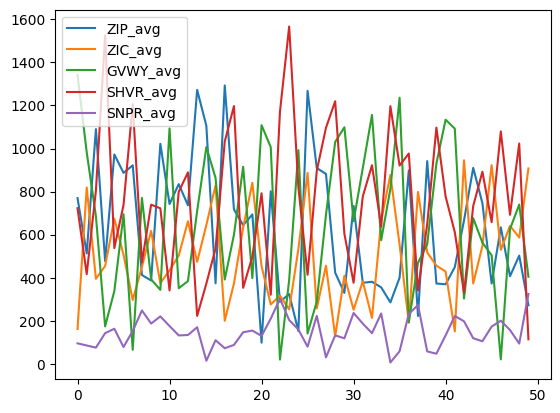

In [163]:
for col in [t + '_avg' for t in traders]:
    plt.plot(profits_df[col], label=col)

plt.legend(loc='upper left')